In [7]:
import warnings
# import os
import pandas as pd
import numpy as np
import math
# import datetime as dt
import matplotlib.pyplot as plt

# import statsmodels.api as sm

# import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

# import plotly.offline as py
# import plotly.graph_objs as go
# import plotly.express as px

# from itertools import product

# from itertools import cycle
# from plotly.subplots import make_subplots

from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             explained_variance_score, r2_score,
                             mean_poisson_deviance, mean_gamma_deviance,
                             accuracy_score)
# from unittest.mock import call
from sklearn.preprocessing import MinMaxScaler

from global_vars import LOOK_BACK, ROOT_PATH
warnings.filterwarnings("ignore")


Description: This program uses artificial recurrent neural network
             called Long Short Term Memory (LSTM) to predict Bitcoin
             prices using Tensorflow's Keras implementtion of LSTM module

In [8]:
# Import dataframe
input_df = pd.read_csv(ROOT_PATH)

input_df.shape
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3443290 entries, 0 to 3443289
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    object 
 1   low     float64
 2   high    float64
 3   open    float64
 4   close   float64
 5   volume  float64
dtypes: float64(5), object(1)
memory usage: 157.6+ MB


In [9]:
# Convert time format to datetime64
input_df_datetype = input_df.astype({"time": "datetime64"})
print("Null values: " + str(input_df_datetype.isnull().values.sum()))
print("Null values: " + str(input_df_datetype.isnull().values.any()))

Null values: 0
Null values: False


# Plotting the lag plot
https://pythontic.com/pandas/plotting/lag%20plot

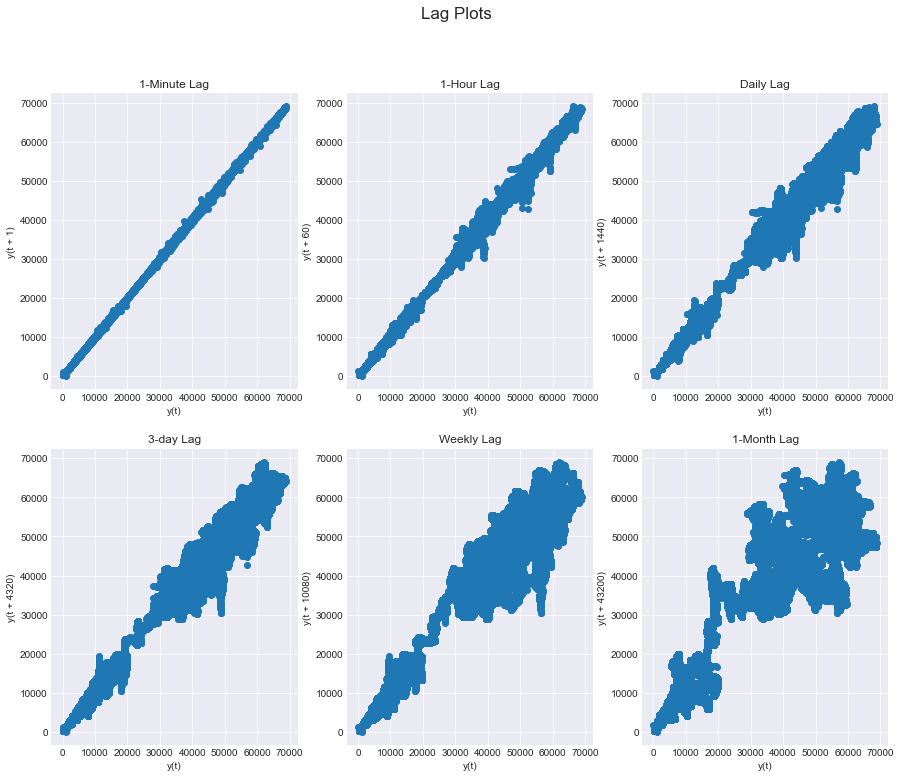

In [10]:
plt.style.use("seaborn-darkgrid")
plt.figure(1, figsize=(15, 12))
plt.suptitle('Lag Plots', fontsize=17)
plt.subplot(2, 3, 1)
pd.plotting.lag_plot(input_df_datetype['close'], lag=1)  # Minute lag
plt.title('1-Minute Lag')

plt.subplot(2, 3, 2)
pd.plotting.lag_plot(input_df_datetype['close'], lag=60)  # Hourley lag
plt.title('1-Hour Lag')

plt.subplot(2, 3, 3)
pd.plotting.lag_plot(input_df_datetype['close'], lag=1440)  # Daily lag
plt.title('Daily Lag')

plt.subplot(2, 3, 4)
pd.plotting.lag_plot(input_df_datetype['close'], lag=4320)  # Daily lag
plt.title('3-day Lag')

plt.subplot(2, 3, 5)
pd.plotting.lag_plot(input_df_datetype['close'], lag=10080)  # Weekly lag
plt.title('Weekly Lag')

plt.subplot(2, 3, 6)
pd.plotting.lag_plot(input_df_datetype['close'], lag=43200)  # Month lag
plt.title('1-Month Lag')

plt.show()

# Plotting the Bitcoin weighted price

<AxesSubplot:title={'center':'Bitcoin Weighted Price'}, xlabel='time'>

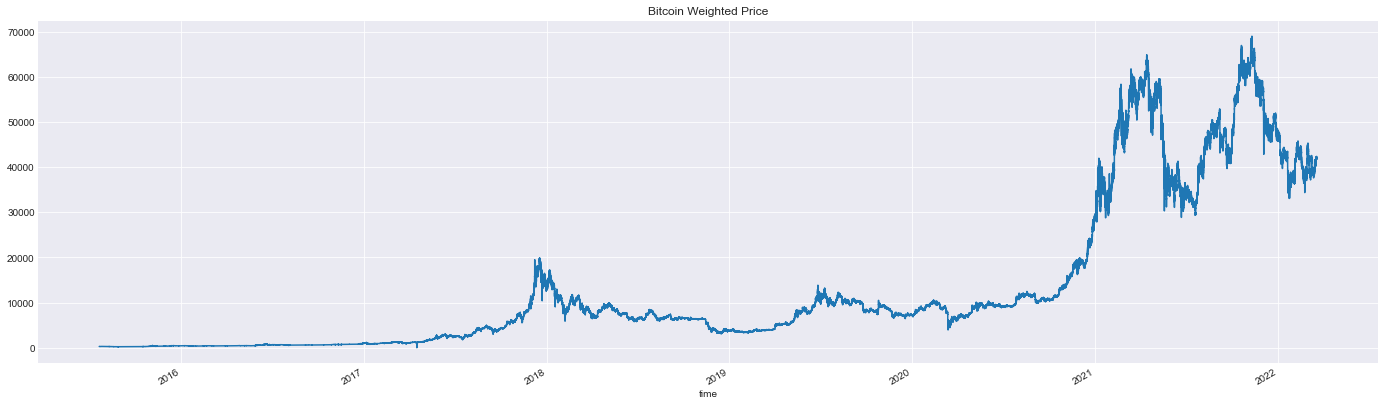

In [11]:

plt.figure(figsize=(15,12))
input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

<i> Add 'date' column to the dataframe </i>

In [12]:
input_df_datetype['date'] = pd.to_datetime(input_df_datetype['time'],unit='s').dt.date

<i> Group dataframe by date </i>

In [13]:
group = input_df_datetype.groupby('date')

<i> Get mean closing value for each date </i>

In [14]:
closing_price_groupby_date = group['close'].mean()
closing_price_groupby_date.info()

<class 'pandas.core.series.Series'>
Index: 2436 entries, 2015-07-20 to 2022-03-20
Series name: close
Non-Null Count  Dtype  
--------------  -----  
2436 non-null   float64
dtypes: float64(1)
memory usage: 38.1+ KB


<i>Set prediction days</i>

In [15]:
prediction_days = 60
data_breakpoint = len(closing_price_groupby_date)-prediction_days

<i> Create train group</i>

In [16]:
df_train = closing_price_groupby_date[:data_breakpoint].values.reshape(-1, 1)
df_train.shape

(2376, 1)

<i> Create test group </i>

In [17]:
df_test = closing_price_groupby_date[data_breakpoint:].values.reshape(-1, 1)
df_test.shape

(60, 1)

<i> Apply MinMax function and fit transform to scaler </i>

In [18]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)
scaled_test = scaler_test.fit_transform(df_test)

# Plotting the training values

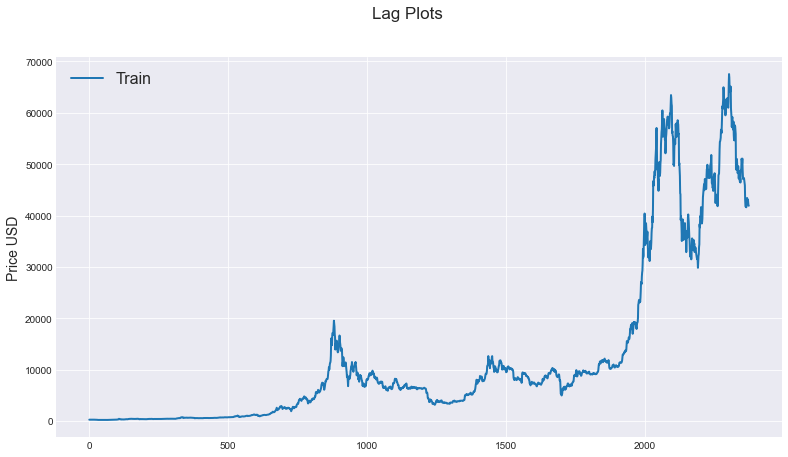

In [19]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train', linewidth=2)
plt.suptitle('Lag Plots', fontsize=17)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

# <i> Function to generate datasets for LSTM </i>

It takes scaled dataset and look_back argument.

Look_back argument defines the size of a time window we'll look back at to predict next timestep

Transforms [1,2,3,4,5,6,7,8,9] etc. into:

    [1,2,3,4,5], [6]

    [2,3,4,5,6], [7]

    [3,4,5,6,7], [8]

Where previous timestamps are used to predict the subsequent time step

In [20]:
def dataset_generator_lstm(dataset, look_back=LOOK_BACK):
    dataX, dataY = [], []

    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]

        dataX.append(window_size_x)
        # This is the label // actual Y value
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)



<i> Create train and test datasets for LSTM from scaled data </i>

In [21]:
trainX, trainY = dataset_generator_lstm(scaled_train)
testX, testY = dataset_generator_lstm(scaled_test)


print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (2369, 7)
trainY:  (2369,)
testX:  (53, 7)
testY (53,)


https://keras.io/api/layers/recurrent_layers/lstm/

For LSTM I need to reshape input into a
3D Tensor of [samples, time steps, features]

Samples - This is the len(dataX), or the amount of data points I have

Time stamps - A sample contains multiple time stamps,
that is, the width of the sliding window.

Note here that it is distinguished from
the sliding step of the sliding window.

So Time Steps is equivalent to the amount of
the time steps I run my recurrent neural network.
Features - this is the amount of features in every time step


In [22]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

The original LSTM model is comprised of single hidden LSTM layer
followed by a standard feedforward output layer.

The Stacked LSTM is and extension to this model that has multiple
hidden LSTM layers where each layer contains multiple memory cells.

I must return return_sequence=True when stacking LSTM layers so that
the second LSTM layer has a cmpatibile n-dimensional sequence input.

I increase the depth of my neural network to add new
layers of abstraction of input observation over time.

Increasing the amount of hidden layers should give me
more accurate predictions over time.

Adding the first LSTM layer and some Dropout regularisation

More on Dropout
https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer

I must set return_sequence to False at the last hidden layer

trainX.shape[1] - number of time steps (5)

trainX.shape[2] - number of features (1)

In [23]:
model = Sequential()
model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=128, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(units=1, input_shape=(1,)))
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             16896     
                                                                 
 dropout (Dropout)           (None, 7, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 115,841
Trainable params: 115,841
Non-trainable params: 0
_________________________________________________________________


Define callbacks to help me have more controll over the training process.

This includes stopping training when you reach a certain accuracy / loss score

Saving my model as a checkpoint after each epoch, adjusting the learning rates over time, and more

In [25]:
# Checkpoint path
checkpoint_path = "my_model.hdf5"

# Callback to save model
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

# Used for stopping training when the least loss is achieved
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50,
                               restore_best_weights=True)


callbacks = [checkpoint, early_stopping]

# Fitting the model 

In [26]:
# TODO: Read fit description
history = model.fit(trainX, trainY, epochs=400,
                    verbose=1, shuffle=False,
                    validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/400
74/75 [============================>.] - ETA: 0s - loss: 0.0139
Epoch 1: val_loss improved from inf to 0.05609, saving model to my_model.hdf5
75/75 [==============================] - 5s 23ms/step - loss: 0.0139 - val_loss: 0.0561
Epoch 2/400
74/75 [============================>.] - ETA: 0s - loss: 0.0254
Epoch 2: val_loss did not improve from 0.05609
75/75 [==============================] - 1s 14ms/step - loss: 0.0254 - val_loss: 0.0879
Epoch 3/400
72/75 [===========================>..] - ETA: 0s - loss: 0.0185
Epoch 3: val_loss did not improve from 0.05609
75/75 [==============================] - 1s 14ms/step - loss: 0.0194 - val_loss: 0.0601
Epoch 4/400
75/75 [==============================] - ETA: 0s - loss: 0.0133
Epoch 4: val_loss did not improve from 0.05609
75/75 [==============================] - 1s 14ms/step - loss: 0.0133 - val_loss: 0.0601
Epoch 5/400
73/75 [============================>.] - ETA: 0s - loss: 0.0108
Epoch 5: val_loss did not improve from 0.05609
75

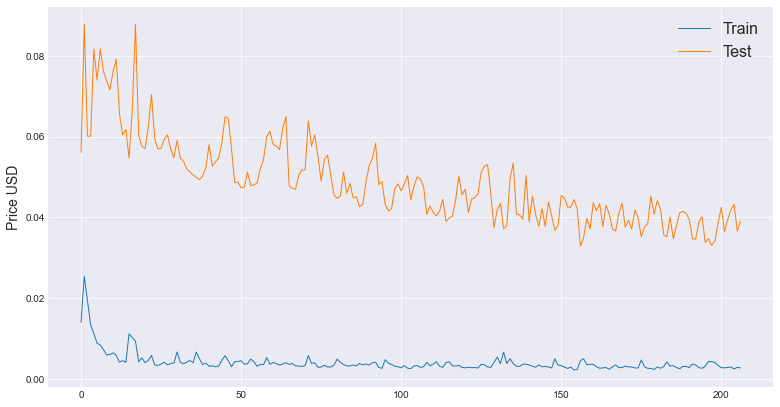

In [27]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(history.history["loss"], label='Train', linewidth=1)
ax.plot(history.history["val_loss"], label="Test", linewidth=1)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

Retrieve saved model

In [28]:
from keras.models import load_model

model_from_saved_checkpoint = load_model("./my_model.hdf5")

<i> Transformation to original form and making the predictions </i>

In [29]:
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

# Plotting prediction against actual testY

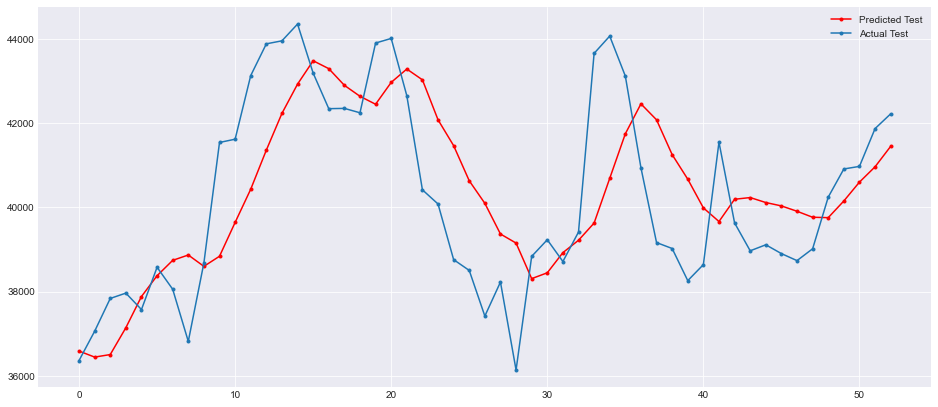

In [30]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

<i> Transformation to original form and making the predictions </i>

In [31]:
#predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

# Plotting prediction against actual trainY

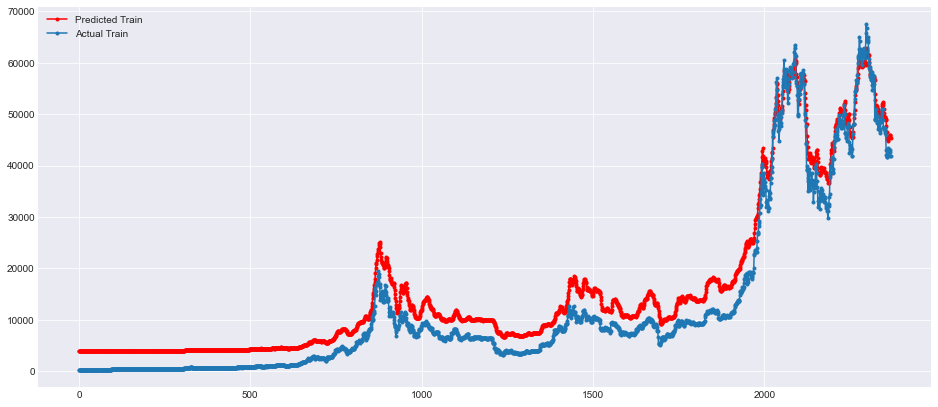

In [32]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')

plt.plot(train_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()

# RMSE - Root mean square error

<i> Train data </i>

In [33]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))
print("Test RMSE: %.3f" % rmse_lstm_test)

Test RMSE: 1675.487


<i> Test data </i>